In [40]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem, ttest_ind
from numpy.polynomial import polynomial
import imageio

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

In [41]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_cell_analysis/"
master_csv = data_dir + 'scnn1a-ppr.csv'
###################################
# SUMATION DECOMPOSITION
# Repeat all these analyses, BUT with single cell ROIs! (from the single cell ROIs dat files)
#    slice and barrel-specific single-cells ROIs are taken and saved in a .dat file
# UPDATE: Every other trace is a single-pulse control, for baseline subtraction and summation decomposition
# UPDATE: Data is right-aligned in the trace, the second pulse is always at point ~360
# Process paired-pulse ratio data
#    - IPIs are shuffled, open <slice>_<loc>shuffle.txt for IPI order
#    - extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
#    - ROIs are in order (in file "<slice>_barrel_rois.dat" for each date subdir):
#          -  medial -> lateral if available
#          - otherwise, in some order that preserves neighbors (1,2 are neighbors and 2,3 are neighbors)
#    - which barrel is home barrel (stimulated) is recorded in master csv scnn1a-ppr.csv for each loc
###################################
enable_photoZ_interact = True
initialize_photoZ = False

# Amp cutoff is slice/loc specific, see scnn1a-ppr.csv

In [42]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()
    # normalization needs to be off since we are saving arrays
    # aPhz.click_normalize_2_array_max()

In [43]:
# load master csv file for metadata
master_df = pd.read_csv(master_csv)
master_df = pd.DataFrame(master_df)
master_df

,Date,Slice_Loc,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,AmpCutoff
0,5/6/2024,1_1,NaN,L4,Rostral,1,1.1
1,5/6/2024,2_1,NaN,L4,Rostral,2,1.1
2,5/9/2024,2_1,NaN,L4,Rostral,2,0.9
3,5/9/2024,2_2,NaN,L4,Rostral,1,0.6
4,5/9/2024,3_1,NaN,L4,Caudal,1,1.1
5,5/14/2024,1_2,NaN,L4,Caudal,1,1.1
6,5/14/2024,2_1,NaN,L4,Rostral,2,1.1
7,5/15/2024,1_1,NaN,L4,Rostral,2,1.1
8,5/15/2024,2_1,NaN,L4,Rostral,2,1.1
9,5/15/2024,3_1,NaN,L4,Rostral,1,1.1


In [44]:
def get_shuffle_filename(slic, loc):
    return str(slic) + "_" + str(loc) + "shuffle.txt"

def get_barrel_roi_filename(slic):
    return str(slic) + "_barrel_rois.dat"

def get_single_cell_roi_filename(slic, barrel_roi):
    return str(slic) + "roi" + str(barrel_roi) + "_single_cell_rois.dat"

def get_tif_filename(slic, loc):
    return str(slic) + "-" + str(loc) + "r.tif"

# locate all files
data_map = {}
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    if not ('selected_zda' in dirs):
        continue
    print("\n", subdir)
    dic_dir = subdir + "/dic/"
    selected_zda_dir = subdir + "/selected_zda/"
    data_map[subdir] = {}
    for zda_file in os.listdir(selected_zda_dir):
        if zda_file.endswith('.zda'):
            slr_id = zda_file.split('.')[0]
            slic_id, loc_id, rec_id = [int(x) for x in slr_id.split("_")]
            print(slic_id, loc_id, rec_id)
            if slic_id not in data_map[subdir]:
                # find ROI file and index it -- NOW USE SINGLE CELL ROIS
                data_map[subdir][slic_id] = {'roi_files': []} 
                for barrel_roi in range(6):
                    roi_file = selected_zda_dir + "/" + get_single_cell_roi_filename(slic_id, barrel_roi)
                    if os.path.exists(roi_file):
                        data_map[subdir][slic_id]['roi_files'].append(roi_file)
            if loc_id not in data_map[subdir][slic_id]:
                # find shuffle file and index it
                data_map[subdir][slic_id][loc_id] = {'zda_files': [],
                                                     'tif_file': subdir + "/" + get_tif_filename(slic_id, loc_id),
                                                     'shuffle_file': subdir + "/" +  get_shuffle_filename(slic_id, loc_id)}
            data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)  # appends in ascending order


 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_cell_analysis/05-14-24
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
2 1 16
2 1 17
2 1 18
2 1 19
2 1 20
2 1 21
2 1 22
2 1 23
2 1 24
2 1 25
2 1 26
2 1 27

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_cell_analysis/05-15-24
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
1 1 16
1 1 17
1 1 18
1 1 19
1 1 20
1 1 21
1 1 22
1 1 23
1 1 24
1 1 25
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
2 1 16
2 1 17
2 1 18
2 1 19
2 1 20
2 1 21
2 1 22
2 1 23
2 1 24
2 1 25
2 1 26
2 1 27
3 1 2
3 1 3
3 1 4
3 1 5
3 1 6
3 1 7
3 1 8
3 1 9
3 1 10
3 1 11
3 1 12
3 1 13

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_cell_analysis/05-16-24
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
1 1 1

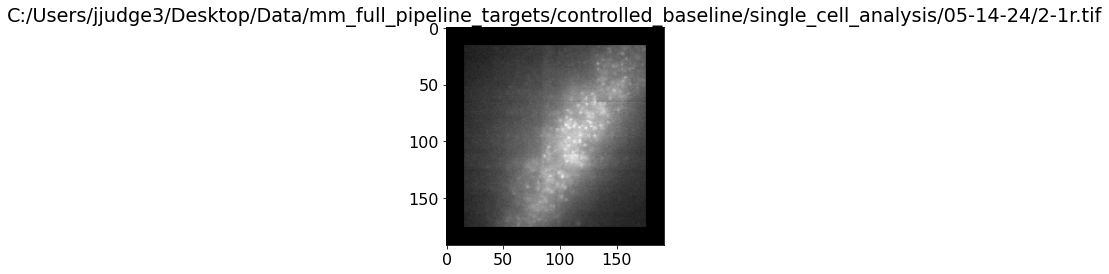

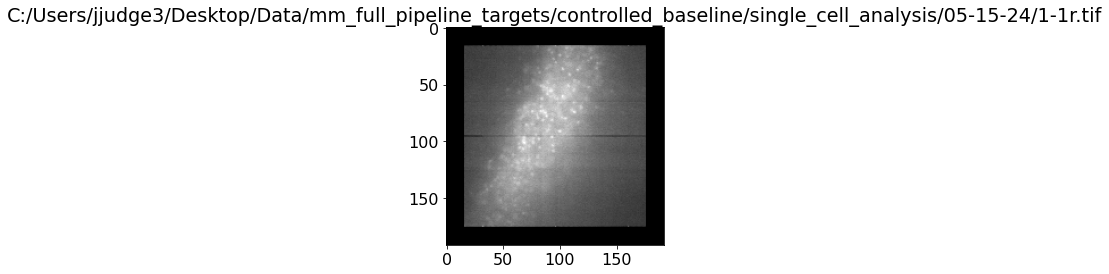

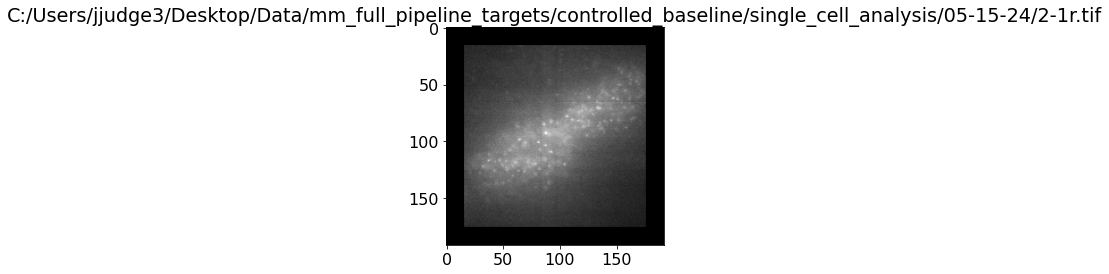

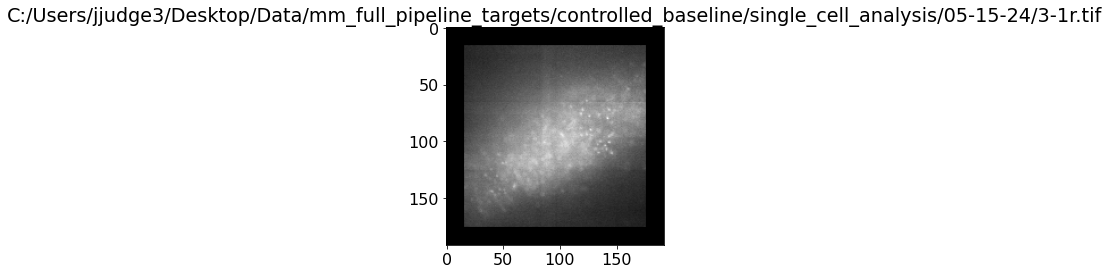

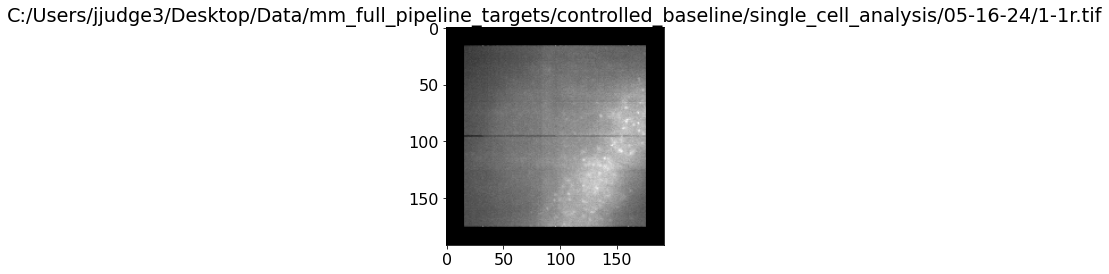

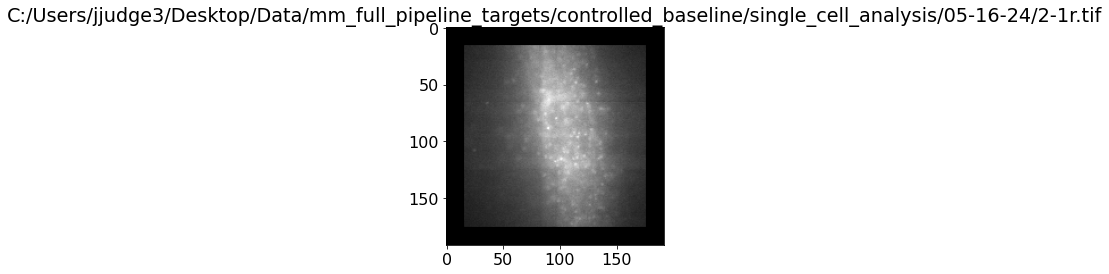

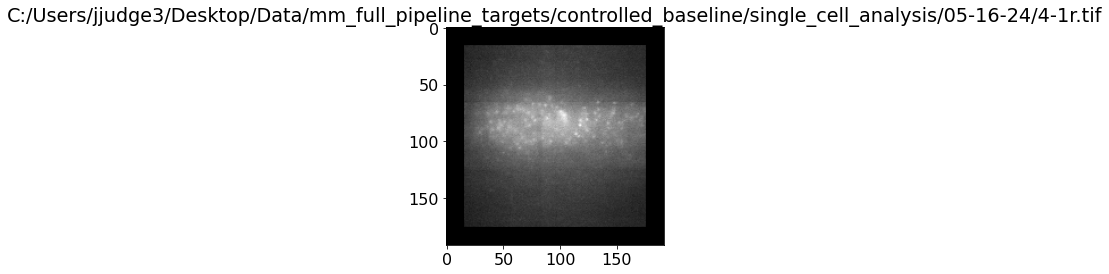

In [45]:
# load tif files, crop array to middle 160x160 pixels, and save as tif file
for subdir in data_map:
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) != int:
                continue
            tif_file = data_map[subdir][slic_id][loc_id]['tif_file']
            if not os.path.exists(tif_file):
                continue
            tif = cv2.imread(tif_file, cv2.IMREAD_GRAYSCALE)
            tif_modified_filename = tif_file.replace(".tif", "_modified.tif")
            tif = tif[:, 176:336]
            # pad all four margins with zeros
            width = 16  # works with PhotoZ X-Position: 39, Y-Position: 32, Width: 567, Height: 568 (minimzed)
            tif = np.pad(tif, ((width, width), (width, width)), 'constant', constant_values=(0, 0))
            

            plt.imshow(tif, cmap='gray')
            plt.title(tif_file)
            plt.show()
            cv2.imwrite(tif_modified_filename, tif)

In [46]:
# go through the IPIs in their shuffled order (ascending recordings) 
# and extract the entire trace for each ROI
# Every second recording is a single-pulse control
initial_sweep = True
if enable_photoZ_interact:
    pa.alert("Starting trace extraction, set trace window to 0,2000 in Save/Load tab!")
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    print(subdir)
    for slic_id in data_map[subdir]:
        roi_files = data_map[subdir][slic_id]['roi_files']

        if enable_photoZ_interact:

            if initial_sweep:
                aPhz.change_baseline_correction(polynomial=False)
                initial_sweep = False

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [x for x in lines]
            control_orders = []
            for k in range(len(ipi_order)):
                ipi = ipi_order[k].split("\t")

                # if there is a third number, it is 0 or 1 for control order. Else control order is 1.
                control_order = 1
                if len(ipi) == 3:
                    control_order = int(ipi[2])
                control_orders.append(control_order)

                ipi = int(ipi[1]) - int(ipi[0])
                
                ipi_order[k] = ipi

            if len(data_map[subdir][slic_id][loc_id]['zda_files']) % 2 != 0:
                raise Exception("Odd number of recordings for", subdir, slic_id, loc_id, "may be missing " +
                                "a single-pulse control!")
            # open zda files in order
            i_ipi = -1
            for i_zda_file in range(0, len(data_map[subdir][slic_id][loc_id]['zda_files']), 2):
                zda_file = data_map[subdir][slic_id][loc_id]['zda_files'][i_zda_file]
                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                    control_order = control_orders[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                

                next_zda_file = data_map[subdir][slic_id][loc_id]['zda_files'][i_zda_file + 1]
                
                # if control_order is 0, then we have to swap zda_file and next_zda_file since the control is first and the recording is second
                if control_order == 0:
                    zda_file, next_zda_file = next_zda_file, zda_file
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])

                # open each of the roi files for the save
                for i_barrel in range(len(roi_files)):
                    roi_file = roi_files[i_barrel]
                                
                    print(roi_file)
                    if enable_photoZ_interact:
                        print("\tOpening barrel ", i_barrel + 1, " ROI file:", roi_file)
                        aPhz.select_roi_tab()
                        aPhz.open_roi_file(roi_file)

                    # save entire traces
                    next_trace_filename = subdir + "/" + "traces_" + slic_loc_id + "_ipi" + str(ipi) + "SC_barrel" + str(i_barrel + 1) + "_control.dat"
                    trace_filename = subdir + "/" + "traces_" + slic_loc_id + "_ipi" + str(ipi) + "SC_barrel" + str(i_barrel + 1) + ".dat"
                    is_loaded_zda_file = False
                    if os.path.exists(trace_filename):
                        print("\tAlready saved trace", trace_filename)
                        is_loaded_zda_file = False
                    elif enable_photoZ_interact:
                        aPhz.open_zda_file(zda_file)
                        time.sleep(13)
                        print("\tSaving traces...")
                        aPhz.save_current_traces(trace_filename, go_to_tab=True)
                        print("\tSaved trace", trace_filename)
                        is_loaded_zda_file = True

                    # save baselined traces
                    trace_baselined_filename = subdir + "/" + "traces_baselined_" + slic_loc_id + "_ipi" + str(ipi) + "SC_barrel" + str(i_barrel + 1) + ".dat"
                    if os.path.exists(trace_baselined_filename):
                        print("\tAlready saved trace", trace_baselined_filename)
                    elif enable_photoZ_interact:
                        if not is_loaded_zda_file:
                            aPhz.open_zda_file(zda_file)
                            time.sleep(13)
                            is_loaded_zda_file = True
                        # now apply baseline correction around both pulses and save the whole trace
                        aPhz.change_baseline_correction(polynomial=True)
                        # set polynomial skip window to eclipse BOTH pulses
                        end_skip = 550
                        first_pulse_start = 356 - (ipi * 2)
                        skip_width = end_skip - first_pulse_start
                        aPhz.set_polynomial_skip_window(first_pulse_start,
                                                        skip_width=skip_width)
                        print("\tSaving traces...")
                        aPhz.save_current_traces(trace_baselined_filename, go_to_tab=True)
                        print("\tSaved trace", trace_baselined_filename)
                        aPhz.change_baseline_correction(polynomial=False)

                    # go to next trace and save control trace
                    if os.path.exists(next_trace_filename):
                        print("\tAlready saved trace", next_trace_filename)
                    elif enable_photoZ_interact:
                        aPhz.open_zda_file(next_zda_file)
                        time.sleep(13)
                        print("\tSaving traces...")
                        aPhz.save_current_traces(next_trace_filename, go_to_tab=True)
                        print("\tSaved trace", next_trace_filename)
                    
                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    if i_barrel + 1 not in data_map[subdir][slic_id][loc_id][ipi]:
                        data_map[subdir][slic_id][loc_id][ipi][i_barrel + 1] = {}

                    data_map[subdir][slic_id][loc_id][ipi][i_barrel + 1] = {'trace': trace_filename,
                                                            'trace_baselined': trace_baselined_filename,
                                                            'control_trace': next_trace_filename}
                if i_ipi < len(ipi_order) - 1:
                    print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_cell_analysis/05-14-24
2 1 IPI: 40 ms for recording 02_01_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_cell_analysis/05-14-24/selected_zda//2roi1_single_cell_rois.dat
	Opening barrel  1  ROI file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_cell_analysis/05-14-24/selected_zda//2roi1_single_cell_rois.dat
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_cell_analysis/05-14-24/traces_2_1_ipi40SC_barrel1.dat
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_cell_analysis/05-14-24/traces_baselined_2_1_ipi40SC_barrel1.dat
	Saving traces...
	Saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_cell_analysis/05-14-24/traces_2_1_ipi40SC_barrel1_control.dat
C:/Users/jjudge3/Desktop/Data/mm

In [47]:
control_match_dist_cutoff = 0.2  # if STDEV of subtraction is greater than this, skip
plot_traces = False

task = "export"  # review or export

# review: see all traces, annotated
if task == 'review':
    remove_filters = True
    export_movie = False
    annotate_traces = True

# export: save filtered traces to gif
if task == 'export':
    remove_filters = False
    export_movie = True
    annotate_traces = False

'''Now load traces and perform summation decomposition by 
subtracting the control trace from the paired-pulse trace. '''
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

df_lists = {'IPI': [], 'ROI': [], 'Medial Dir': [], 'Stim Layer': [], 'Caudal Rostral': [], 'Home Barrel': [],
            'Date': [], 'Slice_Loc': [], 'PPR': [],
            'First Max Composed': [], 'Second Max Composed': [],
            'First Max Controlled': [], 'Second Max Controlled': [], 'PPR Composed': []}


dfs = []
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            amp_cutoff = float(master_df[(master_df['Date'] == date) & (master_df['Slice_Loc'] == slic_loc_id)]['AmpCutoff'].item())
            print(date, slic_loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            movies = {}

            for ipi in data_map[subdir][slic_id][loc_id]:
                for i_barrel in data_map[subdir][slic_id][loc_id][ipi]:
                    if type(ipi) == str:
                        continue
                    print("\tIPI:", ipi)

                    # load traces and control traces for this ipi
                    trace_filename = data_map[subdir][slic_id][loc_id][ipi][i_barrel]['trace']
                    control_trace_filename = data_map[subdir][slic_id][loc_id][ipi][i_barrel]['control_trace']
                    trace_baselined_filename = data_map[subdir][slic_id][loc_id][ipi][i_barrel]['trace_baselined']
                    trace = read_dat_trace_file(trace_filename)
                    control_trace = read_dat_trace_file(control_trace_filename)
                    baselined_trace = read_dat_trace_file(trace_baselined_filename)

                    # show both traces and their subtraction
                    trace_sub = trace - control_trace
                    trace_sub = trace_sub.drop(columns=['Pt'])
                    trace_sub = trace_sub.dropna()

                    # calculate dist from zero of subtracted trace before second stim
                    trace_sub_dist = trace_sub[(trace_sub.index < 356) | (trace_sub.index > 550)].abs().mean()

                    # calculate maxAmp of subtracted trace in measure window (356 - 450)
                    trace_sub_max = trace_sub[(trace_sub.index > 356) & (trace_sub.index < 450)].max()

                    # perform baseline subtraction on control trace
                    first_stim_start = 356 - (ipi * 2)
                    exclusion_window = (first_stim_start, first_stim_start + 290)
                    bc = BaselineCorrection(control_trace, exclusion_windows=[exclusion_window])
                    control_trace_max = {}
                    control_trace_corrected = {}
                    for roi in control_trace.columns:
                        if roi == 'Pt':
                            continue
                        control_trace_corrected[roi] = bc.fit_baseline(roi, date+ " " + slic_loc_id + " IPI " + str(ipi) + "ms")
                        # measure MaxAmp of control trace in first stim site measure window

                        control_trace_max[roi] = control_trace[(control_trace.index > first_stim_start) 
                                                            & (control_trace.index < first_stim_start + 104)]['Corrected_'+roi].max()
                    
                    # extract first and second maxAmp of baselined_trace
                    first_max_baselined = baselined_trace[(baselined_trace.index > first_stim_start) & 
                                                        (baselined_trace.index < 345)].max()
                    second_max_baselined = baselined_trace[(baselined_trace.index > 356) & (baselined_trace.index < 550)].max()

                    for roi in control_trace.columns:
                        if not ('ROI' in roi and len(roi) == 4):
                            continue
                        if roi not in trace.columns:
                            continue

                        n_roi = int(roi[3])

                        # filters
                        if not remove_filters:
                            if trace_sub_dist[roi] > control_match_dist_cutoff:  # skip if magnitude of subtraction is too high
                                continue
                            if trace_sub_max[roi] < amp_cutoff and control_trace_max[roi] < amp_cutoff:  # skip if maxAmp of subtraction is too low
                                continue
                        if plot_traces:
                            plt.rcParams["figure.figsize"] = 10, 3
                            plt.rcParams.update({'font.size': 12})
                            fig, axes = plt.subplots(ncols=2, gridspec_kw={"width_ratios":[4, 1]})
                            axes[0].plot(trace[roi], c='tab:orange', label= roi + ' raw')
                            axes[0].plot(control_trace[roi], 'k--', label= roi + ' control', alpha=0.5)
                            axes[0].plot(trace_sub[roi], c='tab:blue', label= roi + ' subtraction = raw - control')
                            axes[0].plot(control_trace_corrected[roi], c='tab:blue', label= roi + ' control w/ polyfit', alpha=0.5)

                            ceiling_1 = 1.2 * trace[roi].max()
                            axes[0].plot(baselined_trace[roi] + ceiling_1, c='tab:green', label= roi + ' raw w/ polyfit', alpha=0.5)
                            axes[0].annotate("Mean dist:\n" + str(trace_sub_dist[roi])[:5], 
                                            xy=(100, 1), fontsize=8, color='tab:blue')
                            if annotate_traces:
                                # annotate maxAmp of subtracted trace
                                axes[0].annotate("2nd maxAmp: " + str(trace_sub_max[roi])[:5], xy=(450, 3), fontsize=8, color='tab:blue')
                                # annotate maxAmp of control trace
                                axes[0].annotate("1st maxAmp: " + str(control_trace_max[roi])[:5], xy=(200, 5), fontsize=8, color='tab:blue')

                                # annotate maxAmp of baselined trace
                                axes[0].annotate("2nd maxAmp: " + str(second_max_baselined[roi])[:5], xy=(450, 3+ceiling_1), 
                                                fontsize=8, color='tab:green')
                                # annotate maxAmp of baselined trace
                                axes[0].annotate("1st maxAmp: " + str(first_max_baselined[roi])[:5], xy=(200, 5+ ceiling_1),
                                                fontsize=8, color='tab:green')

                            h, l = axes[0].get_legend_handles_labels()
                            axes[1].legend(h, l, borderaxespad=0)
                            axes[1].axis('off')
                            axes[0].set_yticks([])
                            plt.title(date + " " + slic_loc_id + " IPI " + str(ipi) + "ms" + " Barrel " + str(i_barrel + 1) + " ROI " + roi)
                            if export_movie:
                                png_filename = subdir + "/Plot-traces" + slic_loc_id + "_IPI" + str(ipi) + "_" + roi + ".png"
                                plt.savefig(png_filename, dpi=300, bbox_inches='tight')
                                
                                if roi not in movies:
                                    movies[roi] = {}
                                movies[roi][ipi] = png_filename
                            plt.show()


                        # traces not filtered out: calculate PPR and save metadata to snr_dfs
                        ppr = 0
                        print("Amplitudes controlled:", control_trace_max[roi], trace_sub_max[roi])
                        if control_trace_max[roi] != 0:
                            ppr = trace_sub_max[roi] / control_trace_max[roi]

                        # baselined maxamps to composed PPR
                        ppr_composed = 0
                        if first_max_baselined[roi] != 0:
                            ppr_composed = second_max_baselined[roi] / first_max_baselined[roi]

                        if not (0 < ppr < 3 or 0 < ppr_composed < 3):
                            continue

                        df_lists['IPI'].append(ipi)
                        df_lists['ROI'].append(n_roi)
                        df_lists['Medial Dir'].append(medial_dir)
                        df_lists['Stim Layer'].append(stim_layer)
                        df_lists['Caudal Rostral'].append(caudal_rostral)
                        df_lists['Home Barrel'].append(home_barrel)
                        df_lists['Date'].append(date)
                        df_lists['Slice_Loc'].append(slic_loc_id)
                        df_lists['PPR'].append(ppr)
                        df_lists['First Max Composed'].append(first_max_baselined[roi])
                        df_lists['Second Max Composed'].append(second_max_baselined[roi])
                        df_lists['First Max Controlled'].append(control_trace_max[roi])
                        df_lists['Second Max Controlled'].append(trace_sub_max[roi])
                        df_lists['PPR Composed'].append(ppr_composed)
                
                # save movies
                if export_movie:
                    for roi in movies:
                        roi_movie = movies[roi]
                        ipis_keys = list(roi_movie.keys())
                        ipis_keys.sort()
                        roi_movie = [roi_movie[ipi] for ipi in ipis_keys]
                        roi_movie = [imageio.imread(img) for img in roi_movie]
                        gif_filename = subdir + "/IPIs_" + slic_loc_id + roi + ".gif"
                        imageio.mimsave(gif_filename, roi_movie, fps=5)
                        print("created movie", gif_filename)
                



5/14/2024 2_1
	IPI: 40
	IPI: 40
	IPI: 40
	IPI: 20
	IPI: 20
	IPI: 20
	IPI: 130
	IPI: 130
	IPI: 130
	IPI: 120
	IPI: 120
	IPI: 120
	IPI: 60
	IPI: 60
	IPI: 60
	IPI: 70
	IPI: 70
	IPI: 70
	IPI: 30
	IPI: 30
	IPI: 30
	IPI: 100
	IPI: 100
	IPI: 100
	IPI: 50
	IPI: 50
	IPI: 50
	IPI: 80
	IPI: 80
	IPI: 80
	IPI: 110
	IPI: 110
	IPI: 110
	IPI: 10
	IPI: 10
	IPI: 10
	IPI: 90
	IPI: 90
	IPI: 90
5/15/2024 1_1
	IPI: 60
	IPI: 60
Amplitudes controlled: 1.1589681672745207 0.8769299999999998
	IPI: 60
	IPI: 130
	IPI: 130
Amplitudes controlled: 1.2179650198164715 1.1503099999999997
Amplitudes controlled: 1.300204885529987 1.1135899999999999
	IPI: 130
	IPI: 100
Amplitudes controlled: 1.1808547270337328 0.8079899999999998
	IPI: 100
Amplitudes controlled: 1.2458347066124618 0.9904899999999999
Amplitudes controlled: 1.1421454183272806 1.0002900000000006
Amplitudes controlled: 1.3140418401932163 1.0228700000000002
	IPI: 100
	IPI: 40
	IPI: 40
Amplitudes controlled: 1.0456602357833669 1.16486
Amplitudes controlled: 1.106

In [48]:
# create dataframe from df_lists
df = pd.DataFrame.from_dict(df_lists)
numeric_cols = ['IPI', 'ROI', 'PPR', 'Home Barrel']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
dfs.append(df)
csv_filename = 'scnn1a-ppr-output_all.csv'
df.to_csv(data_dir + csv_filename, index=False)
df

,IPI,ROI,Medial Dir,Stim Layer,Caudal Rostral,Home Barrel,Date,Slice_Loc,PPR,First Max Composed,Second Max Composed,First Max Controlled,Second Max Controlled,PPR Composed
0,60,9,NaN,L4,Rostral,2,5/15/2024,1_1,0.756647,0.834668,1.096500,1.158968,0.87693,1.313696
1,130,5,NaN,L4,Rostral,2,5/15/2024,1_1,0.944452,1.198690,1.018110,1.217965,1.15031,0.849352
2,130,6,NaN,L4,Rostral,2,5/15/2024,1_1,0.856473,1.111590,0.943107,1.300205,1.11359,0.848431
3,100,5,NaN,L4,Rostral,2,5/15/2024,1_1,0.684242,0.531158,0.647690,1.180855,0.80799,1.219392
4,100,4,NaN,L4,Rostral,2,5/15/2024,1_1,0.795041,0.785527,0.881314,1.245835,0.99049,1.121940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,110,9,NaN,L4,Rostral,1,5/16/2024,4_1,0.681071,1.238970,0.910856,1.977034,1.34650,0.735172
190,80,6,NaN,L4,Rostral,1,5/16/2024,4_1,0.633618,1.350490,0.927241,1.877424,1.18957,0.686596
191,80,9,NaN,L4,Rostral,1,5/16/2024,4_1,0.687237,1.433310,0.841875,1.653725,1.13650,0.587364
192,20,9,NaN,L4,Rostral,1,5/16/2024,4_1,0.611658,1.156490,1.183800,1.540044,0.94198,1.023615


In [49]:
for date in df['Date'].unique():
    print(df[df['Date'] == date]['Slice_Loc'].unique())

['1_1' '2_1' '3_1']
['1_1' '2_1' '4_1']


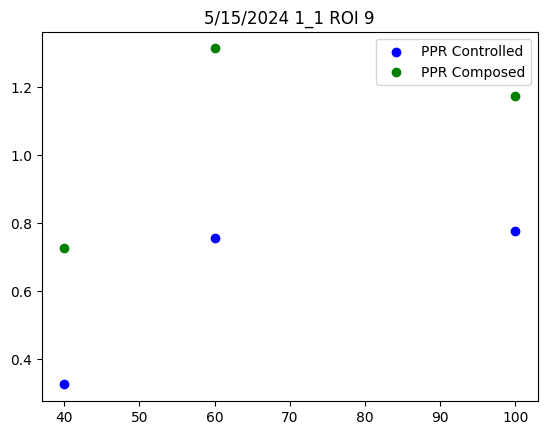

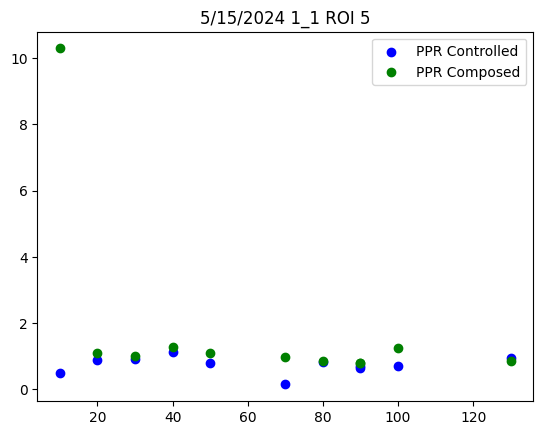

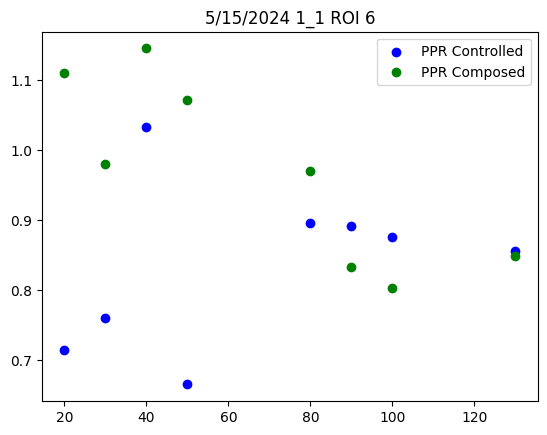

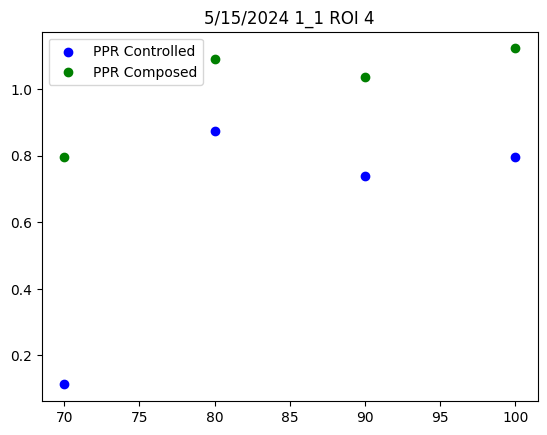

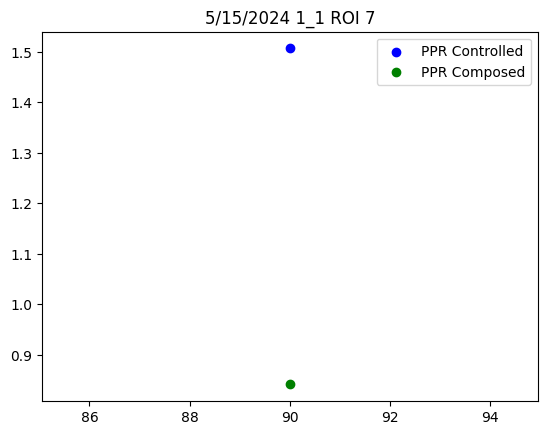

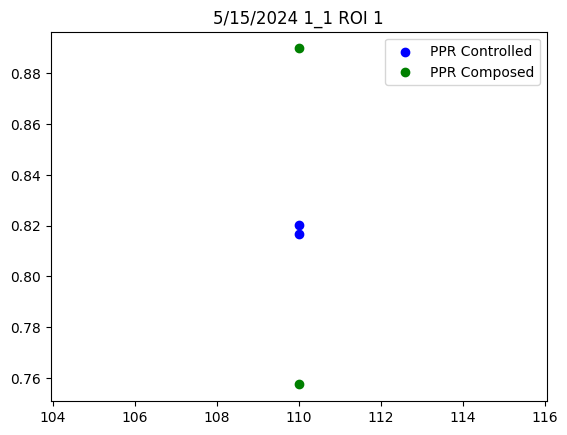

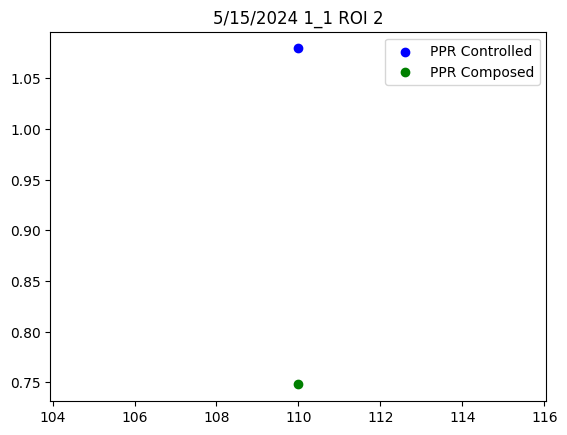

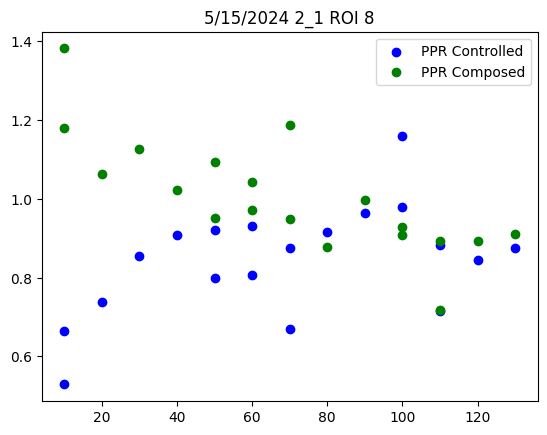

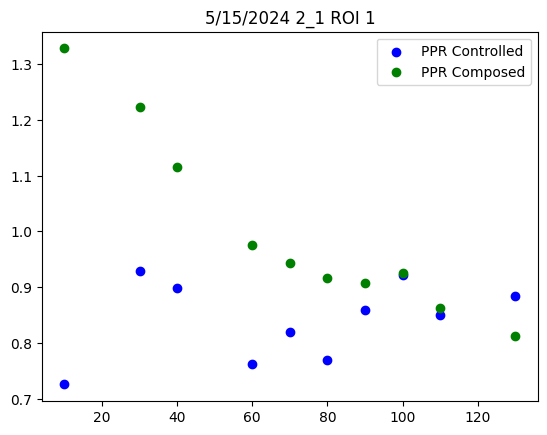

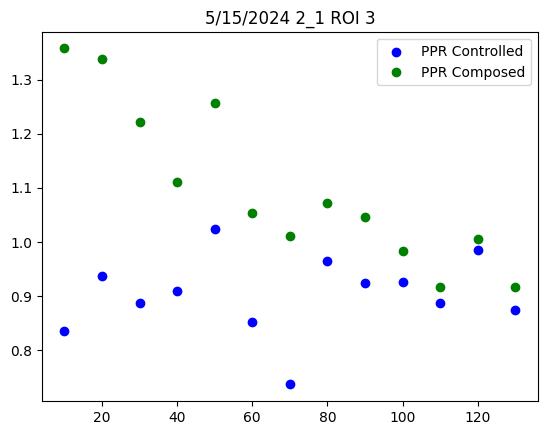

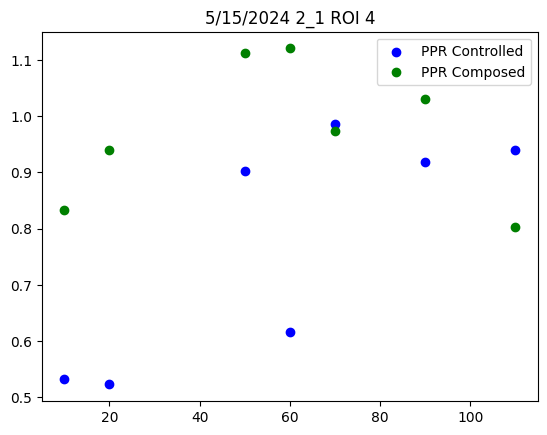

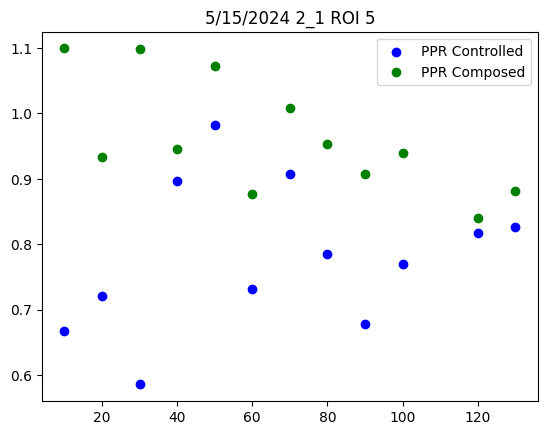

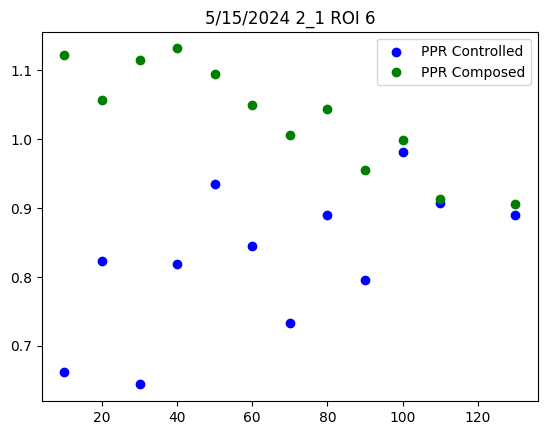

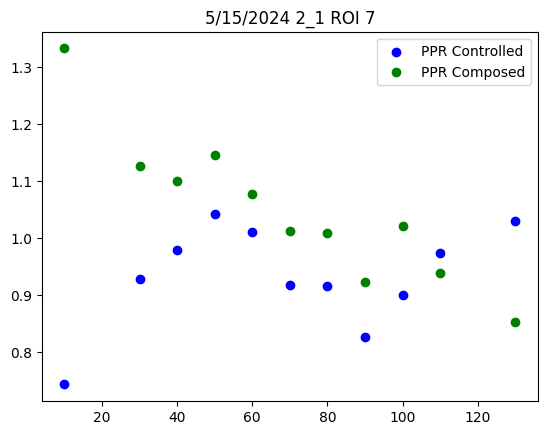

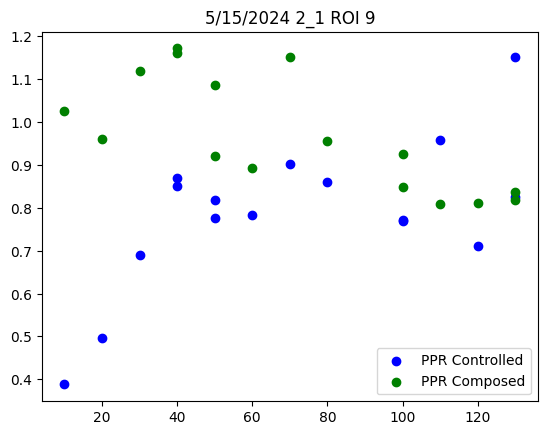

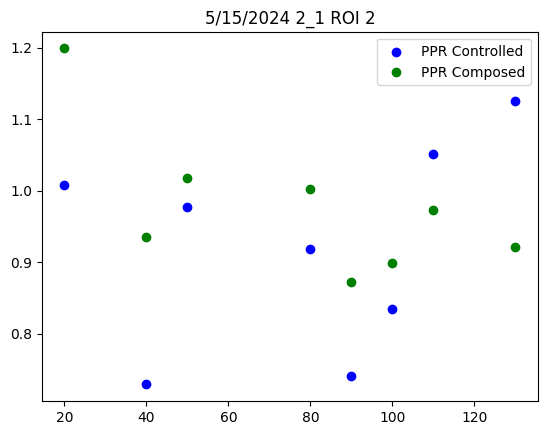

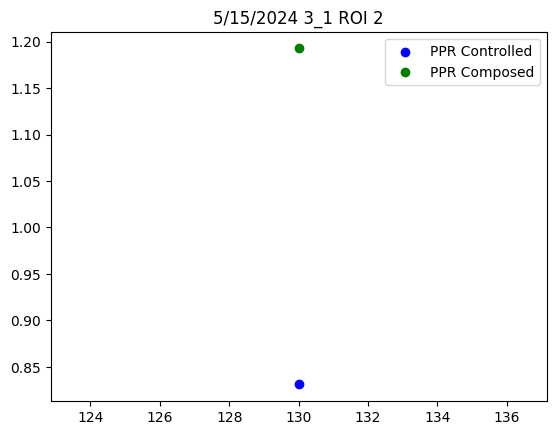

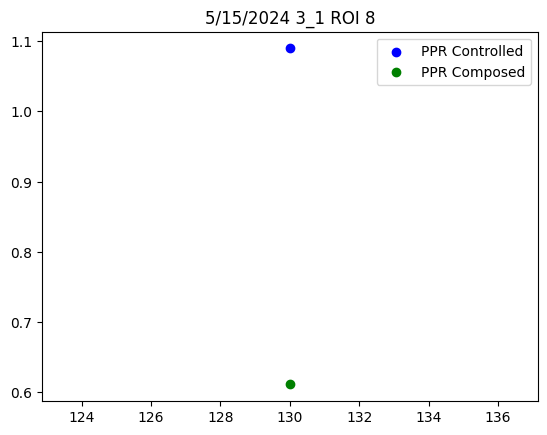

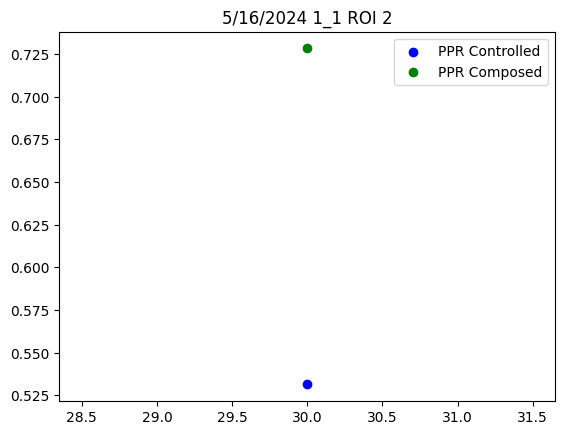

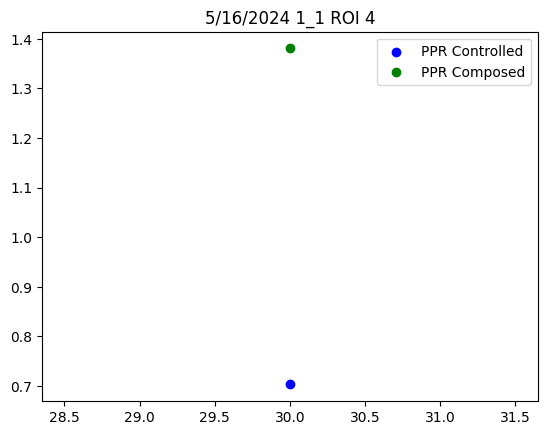

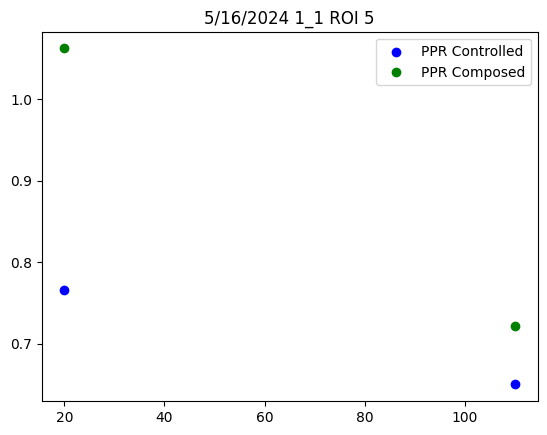

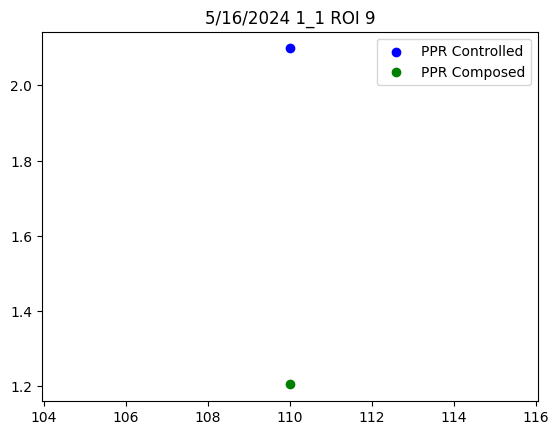

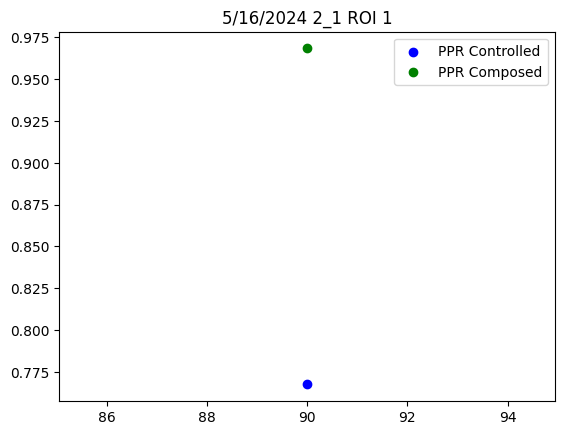

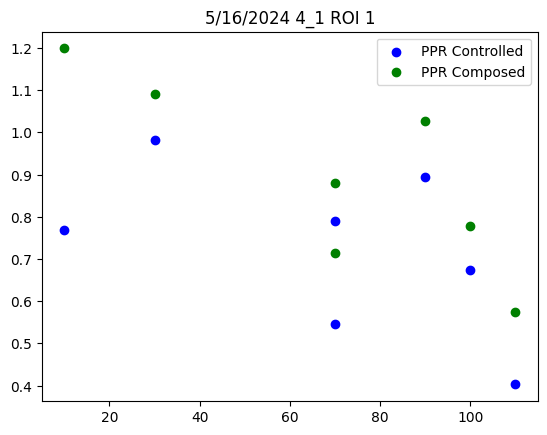

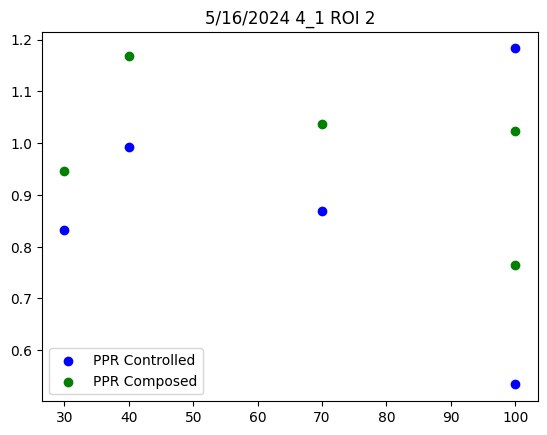

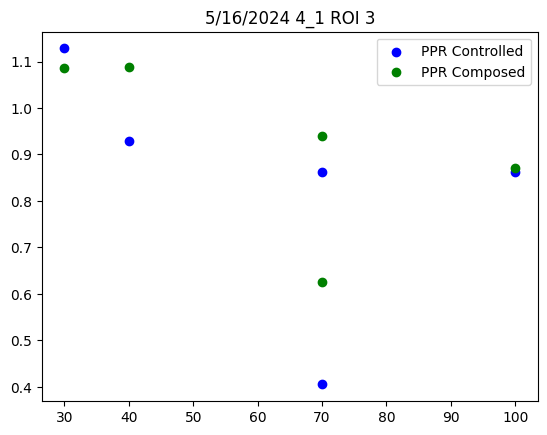

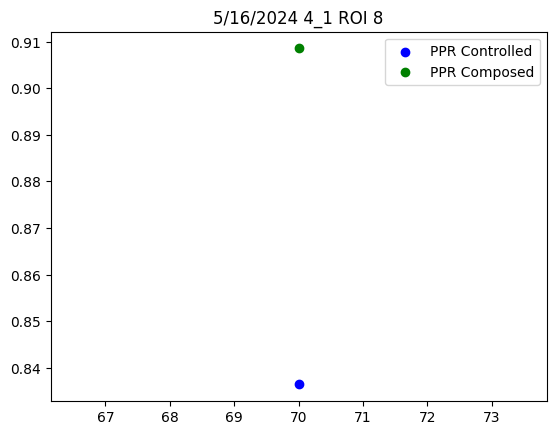

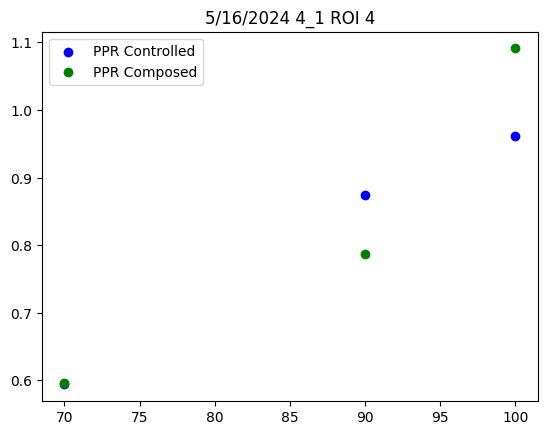

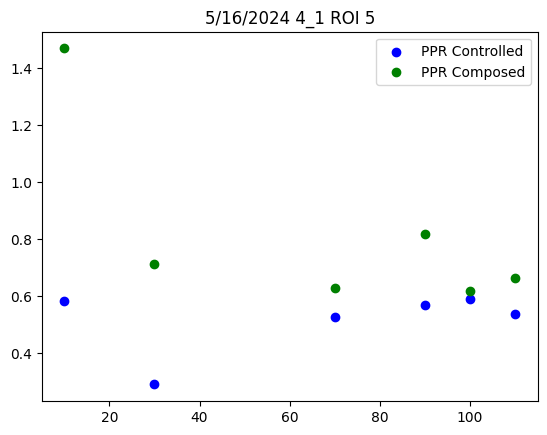

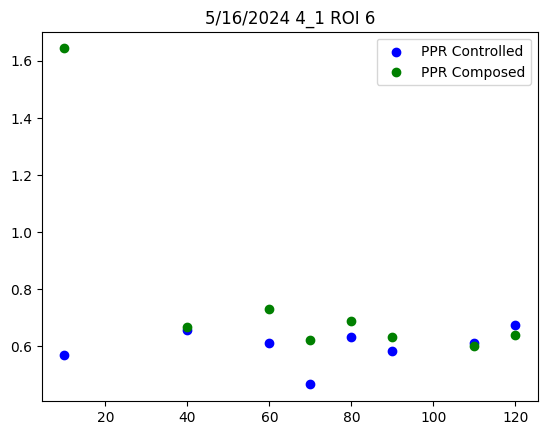

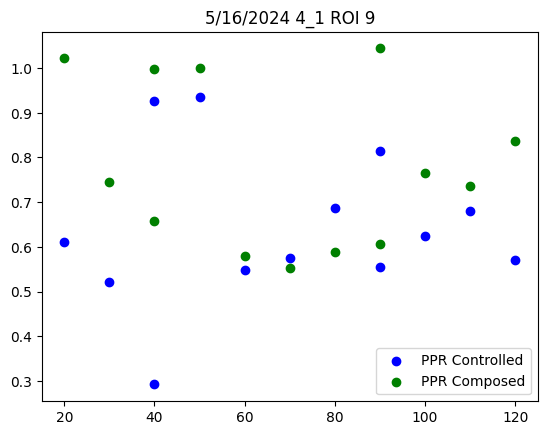

In [50]:
# for each date, slice/loc, and ROI, plot PPR vs IPI
plt.rcParams.update(plt.rcParamsDefault)
for date in df['Date'].unique():
    pfs_date = df[df["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():

            # plot PPR
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPR'], label='PPR Controlled', c = 'b')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))

            # plot PPR Composed
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPR Composed'], label='PPR Composed', c='g')
            plt.legend()

            plt.show()
            '''plt.scatter(pfs_roi['IPI'], pfs_roi['PPL'], c='r')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPHW'], c='g')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()'''

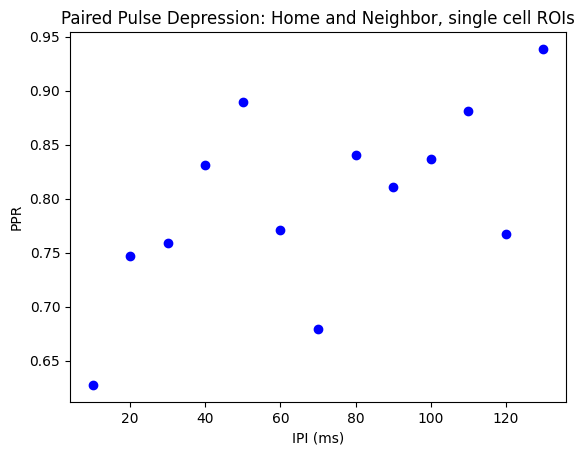

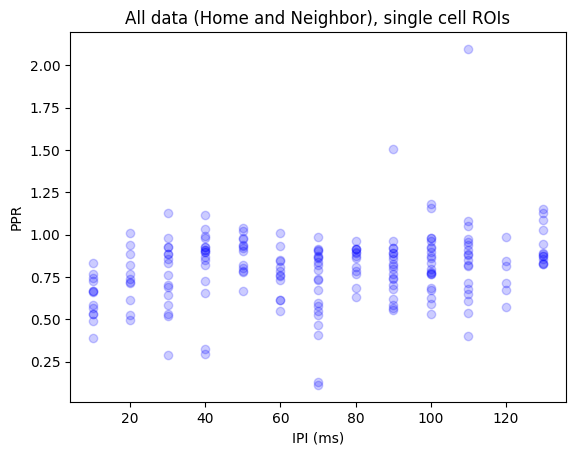

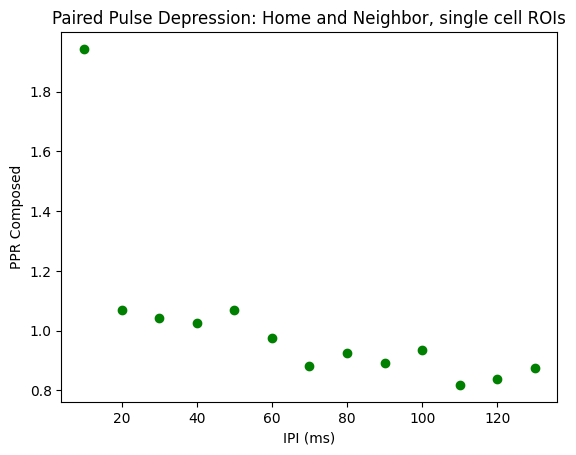

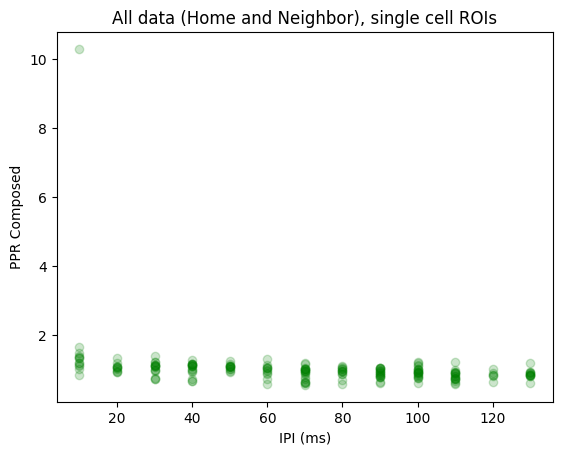

In [51]:
# average grouping by IPI
for pp_type, color in [['PPR', 'b'], ['PPR Composed', 'g']]: #, ['PPL', 'r'], ['PPHW', 'g']]:
    group_by_ipi = df[['IPI', pp_type]].groupby(by=['IPI']).mean()
    group_by_ipi_std = df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std)
    group_by_ipi.reset_index(inplace=True)
    
    

    # plot average PPR vs IPI
    plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
    plt.title("Paired Pulse Depression: Home and Neighbor, single cell ROIs")
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.show()
    plt.scatter(df['IPI'], df[pp_type], alpha=0.2, c=color)
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.title("All data (Home and Neighbor), single cell ROIs")
    plt.show()

     PPR
IPI     
10     1
20     1
30     1
40     1
50     1
70     2
80     1
90     2
100    2
110    3
130    1
i= 0
10
p_val for IPI 20 : nan
p_val for IPI 30 : nan
p_val for IPI 40 : nan
p_val for IPI 50 : nan
p_val for IPI 70 : nan
p_val for IPI 80 : nan
p_val for IPI 90 : nan
p_val for IPI 100 : nan
p_val for IPI 110 : nan
p_val for IPI 130 : nan
[None, None, None, None, None, None, None, None, None, None, None]
     PPR
IPI     
10    12
20    10
30    15
40    16
50    12
60    12
70    19
80    12
90    18
100   19
110   15
120    6
130   12
i= 1
110
p_val for IPI 10 : 0.006781711835029157
p_val for IPI 20 : 0.06106039092445144
p_val for IPI 30 : 0.09719215075674256
p_val for IPI 40 : 0.32236366662507326
p_val for IPI 50 : 0.4753399054718605
p_val for IPI 60 : 0.12930349456576523
p_val for IPI 70 : 0.03542995238761974
p_val for IPI 80 : 0.2895418990502222
p_val for IPI 90 : 0.23441631476449049
p_val for IPI 100 : 0.3378780341399825
p_val for IPI 120 : 0.14338925664215182
p_

c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, dd

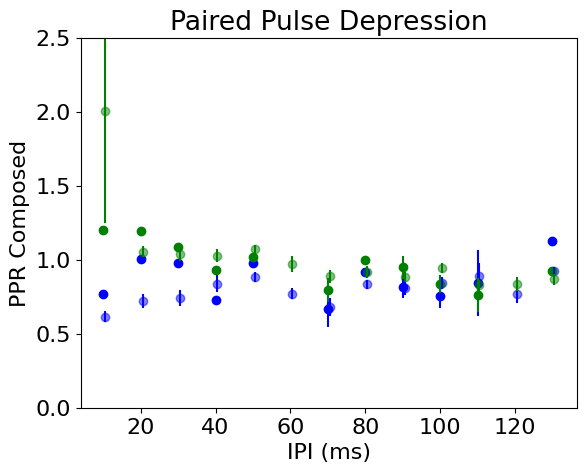

In [64]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = df.query('`Home Barrel` == ROI')
neighbor_barrel_df = df.query('`Home Barrel` != ROI')
all_barrels_df = df
titles = ['Home Barrel', 'Neighbor Barrel', 'Barrels']

for pp_type, color in [['PPR', 'b'], ['PPR Composed', 'g']]: #, ['PPL', 'r'], ['PPHW', 'g']]:
    i = 0
    for barrel_df in [home_barrel_df, neighbor_barrel_df]:

        
        if pp_type in ['PPL', 'PPHW']:
            barrel_df = barrel_df[barrel_df['IPI'] > 20]
        group_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).mean()
        group_by_ipi_std = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std) / np.sqrt(barrel_df[['IPI', pp_type]].groupby(by=['IPI']).count())
        group_by_ipi.reset_index(inplace=True)

        count_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).count()
        print(count_by_ipi)

        # significance tests against the first IPI
        first_ipi = np.min(group_by_ipi['IPI'])
        pvals = []
        print("i=", i)
        if pp_type == 'PPR' and titles[i] == 'Neighbor Barrel':
            first_ipi = 110
        print(first_ipi)
        
        first_ipi_data = barrel_df[barrel_df['IPI'] == first_ipi][pp_type]
        for ipi in group_by_ipi['IPI']:
            if ipi == first_ipi:
                pvals.append(1)
                continue
            ipi_data = barrel_df[barrel_df['IPI'] == ipi][pp_type]
            
            # one-sided t-test if ipi_data is less than first_ipi_data
            t_stat, p_val = ttest_ind(ipi_data, first_ipi_data, alternative='less', equal_var=False)
            print("p_val for IPI", ipi, ":", p_val)
            pvals.append(p_val)

        def get_sig_level(x):
            if x < 0.001:
                return '***'
            if x < 0.01:
                return '**'
            if x < 0.05:
                return '*'
        significance_levels = [get_sig_level(x) for x in pvals]
        print(significance_levels)
            
        alph = 1
        if "Neighbor" in titles[i]:
            alph = 0.5
        x = group_by_ipi['IPI']
        if titles[i] == 'Neighbor Barrel':
            x = x + 0.5
        plt.scatter(x, group_by_ipi[pp_type], c=color, label=titles[i] + pp_type.replace("PPR", ""), alpha=alph)
        plt.errorbar(x, group_by_ipi[pp_type], 
                     group_by_ipi_std[pp_type], ls='none', c=color)
        y_label = pp_type
        if pp_type == 'PPL':
            y_label = "Paired-pulse ratio\n of Latency"
        if pp_type == 'PPHW':
            y_label = "Paired-pulse ratio\n of Half-width"
        plt.title("Paired Pulse Depression") # in " + titles[i])
        
        # place significance levels on plot
        #for j, txt in enumerate(significance_levels):
        #    plt.annotate(txt, (group_by_ipi['IPI'].iloc[j], min(0.95, group_by_ipi[pp_type].iloc[j] + 0.25)), fontsize=12)

        plt.xlabel("IPI (ms)")
        #plt.xticks([])
        plt.ylabel(y_label)
        i += 1
# plt.legend()
plt.ylim(0, 2.5)
plt.show()


In [53]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = df.query('`Home Barrel` == ROI')
neighbor_barrel_df = df.query('`Home Barrel` != ROI')
pvals = []
# significance tests: home versus neighbor
for ipi in group_by_ipi['IPI']:
    
    # one-sided t-test if ipi_data is less than first_ipi_data
    t_stat, p_val = ttest_ind(neighbor_barrel_df[neighbor_barrel_df['IPI'] == ipi]["PPR"],
                              home_barrel_df[home_barrel_df['IPI'] == ipi]["PPR"],  
                                alternative='less', 
                                equal_var=False)
    print("p_val for IPI", ipi, ":", p_val)
    pvals.append(p_val)

def get_sig_level(x):
    if x < 0.001:
        return '***'
    if x < 0.01:
        return '**'
    if x < 0.05:
        return '*'
significance_levels = [get_sig_level(x) for x in pvals]
print(significance_levels)

p_val for IPI 10 : nan
p_val for IPI 20 : nan
p_val for IPI 30 : nan
p_val for IPI 40 : nan
p_val for IPI 50 : nan
p_val for IPI 60 : nan
p_val for IPI 70 : 0.5301299801822779
p_val for IPI 80 : nan
p_val for IPI 90 : 0.4715549135868863
p_val for IPI 100 : 0.7805348127241624
p_val for IPI 110 : 0.5664032973493845
p_val for IPI 120 : nan
p_val for IPI 130 : nan
[None, None, None, None, None, None, None, None, None, None, None, None, None]


c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, dd

In [54]:
# check for pulse 1 vs pulse 2 changes in latency or halfwidth
alpha = 0.5
should_group_by_ipi = True
if should_group_by_ipi:
    alpha = 1
ppr_snr = df.query('PPR > 0')
ppr_snr = ppr_snr.query('PPR < 2')
pulse1_df = ppr_snr.query('Pulse == 1')
pulse2_df = ppr_snr.query('Pulse == 2')
titles = ['Pulse 1', 'Pulse 2']
pulse_colors = ['tab:orange', 'tab:green']

for barrel in ['Home Barrel', 'Neighbor Barrel']:
    for met_type, color in [['Amp', 'b']]: # , ['Latency', 'r'], ['Halfwidth', 'g']]:
        i = 0
        end1, end2 = None, None
        for pulse_df in [pulse1_df, pulse2_df]:
            total_n = len(pulse_df['IPI'])
            if barrel == 'Home Barrel':
                pulse_df = pulse_df.query('`Home Barrel` == ROI')
            else:
                pulse_df = pulse_df.query('`Home Barrel` != ROI')
            pulse_df = pulse_df[pulse_df['IPI'] > 5]
            subset_n = len(pulse_df['IPI'])
            print(len(pulse_df['IPI']))
            if should_group_by_ipi:
                pulse_df_std = pulse_df[['IPI', met_type]].groupby(by=['IPI']).agg(np.std)
                pulse_df = pulse_df[['IPI', met_type]].groupby(by=['IPI']).mean()
                pulse_df.reset_index(inplace=True)
                plt.errorbar(pulse_df['IPI'] + i * 0.5 - 0.25, pulse_df[met_type], 
                            pulse_df_std[met_type], ls='none', c=pulse_colors[i], capsize=3, alpha=0.4)
            if end1 is None:
                end1 = pulse_df
            else:
                end2 = pulse_df
            plt.scatter(pulse_df['IPI'], pulse_df[met_type], alpha=alpha,
                        s=30,
                        color=pulse_colors[i],
                         label=titles[i] )
            i += 1
        plt.title(barrel)
        plt.xlabel("IPI (ms)")
        plt.ylabel(met_type)
        #plt.ylim(0, 11)
        plt.legend()
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        
        plt.show()
        ppr = end2[met_type] / end1[met_type]
        print(ppr.shape, end1[met_type].shape, end2['IPI'].shape, end1['IPI'].shape)
        plt.scatter(end1['IPI'], ppr)
        plt.show()


UndefinedVariableError: name 'Pulse' is not defined

In [ ]:
# autoPhotoZ to save amplitude arrays for each measure window and 
# baseline correction to create PPR maps
def get_amp_array_filename(subdir, slic_loc_id, ipi, pulse):
    return subdir + "/" + "ampArray_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(pulse) + ".dat"

overwrite_amp_arrays = False
select_amp_bkg = False
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    if not select_amp_bkg and enable_photoZ_interact:
        aPhz.select_MaxAmp_array()
    print(subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [x for x in lines]
            for k in range(len(ipi_order)):
                ipi = ipi_order[k].split("\t")
                ipi = int(ipi[1]) - int(ipi[0])
                ipi_order[k] = ipi

            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:

                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                # check if all amp arrays are already saved for this recording/IPI
                all_saved = True
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename):
                        print("Missing", amp_array_filename)
                        all_saved = False
                        break
                if overwrite_amp_arrays:
                    all_saved = False

                if enable_photoZ_interact and not all_saved:
                    aPhz.open_zda_file(zda_file)

                    # set polynomial skip window to eclipse BOTH pulses
                    end_skip = 550
                    first_pulse_start = 356 - (ipi * 2)
                    skip_width = end_skip - first_pulse_start
                    aPhz.set_polynomial_skip_window(first_pulse_start,
                                                            skip_width=skip_width)
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename) or overwrite_amp_arrays:
                        if enable_photoZ_interact and not all_saved:
                            #measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                            measure_window_start = 356
                            if i_pulse == 1:
                                measure_window_start -= ipi * 2
                            aPhz.set_measure_window(measure_window_start, None)


                        # take Amplitude array from PhotoZ
                        if enable_photoZ_interact and not all_saved:
                            aPhz.save_background(filename=amp_array_filename)
                    else:
                        if not all_saved:
                            time.sleep(5)

                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    if i_pulse not in data_map[subdir][slic_id][loc_id][ipi]:
                        data_map[subdir][slic_id][loc_id][ipi][i_pulse] = {}
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['amp_array'] = amp_array_filename
                    
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)
                        

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/better_baseline/04-24-24
2 1 IPI: 70 ms for recording 02_01_01.zda
2 1 IPI: 10 ms for recording 02_01_02.zda
2 1 IPI: 20 ms for recording 02_01_03.zda
2 1 IPI: 90 ms for recording 02_01_04.zda
2 1 IPI: 60 ms for recording 02_01_05.zda
2 1 IPI: 40 ms for recording 02_01_06.zda
2 1 IPI: 100 ms for recording 02_01_07.zda
2 1 IPI: 130 ms for recording 02_01_08.zda
2 1 IPI: 110 ms for recording 02_01_09.zda
2 1 IPI: 50 ms for recording 02_01_10.zda
2 1 IPI: 30 ms for recording 02_01_11.zda
2 1 IPI: 80 ms for recording 02_01_12.zda
2 1 IPI: 120 ms for recording 02_01_13.zda
3 1 IPI: 120 ms for recording 03_01_02.zda
3 1 IPI: 130 ms for recording 03_01_03.zda
3 1 IPI: 80 ms for recording 03_01_04.zda
3 1 IPI: 40 ms for recording 03_01_05.zda
3 1 IPI: 90 ms for recording 03_01_06.zda
3 1 IPI: 70 ms for recording 03_01_07.zda
3 1 IPI: 30 ms for recording 03_01_08.zda
3 1 IPI: 60 ms for recording 03_01_09.zda
3 1 IPI: 50 ms for recording 03_

In [ ]:
# use amp arrays of both pulses to create PPR maps of different IPIs of the recordings 
def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr

area_by_ipi = {'ipi': [], 'area': []}
ppr_hist = []
pphw_hist = []
ppl_hist = []
amp_cutoff = 1
# load in amp array files into dataframe for each IPI
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            for ipi in data_map[subdir][slic_id][loc_id]:

                if type(ipi) == str:
                    continue
                
                # load amp files as numpy arrays using np.loadtxt
                amp_arr1 = get_amp_array_filename(subdir, slic_loc_id, ipi, 1)
                amp_arr2 = get_amp_array_filename(subdir, slic_loc_id, ipi, 2)
                amp_arr1 = read_dat_arr_file(amp_arr1)
                amp_arr2 = read_dat_arr_file(amp_arr2)
                ppr_map = amp_arr2 / amp_arr1

                area1 = np.sum(amp_arr1 > amp_cutoff)
                area2 = np.sum(amp_arr2 > amp_cutoff)
                if area1 > 0:
                    area_ratio = area2 / area1
                    area_by_ipi['area'].append(area_ratio)
                    area_by_ipi['ipi'].append(ipi)

                ppr_map[amp_arr1 < amp_cutoff] = 0
                '''if np.sum(ppr_map) > 0:
                    fig, axes = plt.subplots(1, 2)
                    axes[0].imshow(ppr_map, cmap='viridis')
                    axes[1].imshow(ppr_map > 1, cmap='viridis')
                    plt.show()
                    #print(np.max(ppr_map), np.min(ppr_map))'''

                # build histogram of PPR values for pixels above cutoff
                for i in range(amp_arr1.shape[0]):
                    for j in range(amp_arr1.shape[1]):
                        if amp_arr1[i, j] > amp_cutoff * 3 and 0 < ppr_map[i, j] < 2 and amp_arr2[i, j] != amp_arr1[i, j]:
                            ppr_hist.append(ppr_map[i, j])


<ipython-input-216-bd3863ed5157>:46: RuntimeWarning: divide by zero encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1
<ipython-input-216-bd3863ed5157>:46: RuntimeWarning: invalid value encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1


<ipython-input-234-1c0c101795ff>:46: RuntimeWarning: divide by zero encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1
<ipython-input-234-1c0c101795ff>:46: RuntimeWarning: invalid value encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1


           params       sigma
mu1      0.810105    4.321200
sigma1   0.124662    1.083099
A1       6.434943  246.493731
mu2      0.920718    0.156720
sigma2   0.103106    0.086940
A2      42.080217  328.991449


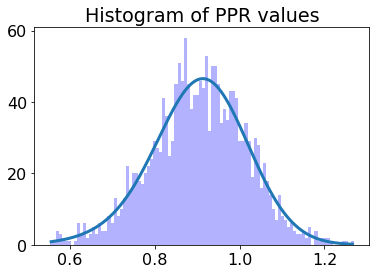

In [ ]:

# plot histogram of PPR values
y,x,_=plt.hist(ppr_hist, bins=100, color='b', alpha=0.3)
plt.title("Histogram of PPR values")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
np.random.seed(123)
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected = (0.7, .02, 25, 0.8, .02, 15)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='tab:blue', lw=3)
#...and individual Gauss curves
'''plt.plot(x_fit, gauss(x_fit, *params[:3]), 
         color='tab:orange', lw=3, ls="--", label='mean PPR: 0.74 ± 0.01' )
plt.plot(x_fit, gauss(x_fit, *params[3:]), 
         color='tab:green', lw=3, ls=":", label='mean PPR: 0.82 ± 0.07')'''
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")
#plt.legend(loc = 'upper left')
#plt.ylim(0, 17)
#plt.xlim(0.2, 1.2)
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show() 